# Prophet: Denmark
Denna notebook innefattar en analys av datasetet som finns i 'dk.csv'.

#### Importerar bibliotek

In [108]:
from datetime import datetime, timedelta

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.tools as tls
from prophet import Prophet

#### Importerar data

In [109]:
dk_data = pd.read_csv('dk.csv')

## Grundläggande analys av datan
Vår data ser ut att ha energilast för landet från och med 1 Januari 2015 till och med 31 Juli 2020. Datan är indelad timvis.

In [110]:
dk_data.head()

start                        end    load
0  2015-01-01 00:00:00+00:00  2015-01-01 01:00:00+00:00  3211.0
1  2015-01-01 01:00:00+00:00  2015-01-01 02:00:00+00:00  3100.0
2  2015-01-01 02:00:00+00:00  2015-01-01 03:00:00+00:00  2980.0
3  2015-01-01 03:00:00+00:00  2015-01-01 04:00:00+00:00  2933.0
4  2015-01-01 04:00:00+00:00  2015-01-01 05:00:00+00:00  2942.0

In [111]:
dk_data.tail()

start                        end    load
48929  2020-07-31 19:00:00+00:00  2020-07-31 20:00:00+00:00  3353.0
48930  2020-07-31 20:00:00+00:00  2020-07-31 21:00:00+00:00  3242.0
48931  2020-07-31 21:00:00+00:00  2020-07-31 22:00:00+00:00  3015.0
48932  2020-07-31 22:00:00+00:00  2020-07-31 23:00:00+00:00  2813.0
48933  2020-07-31 23:00:00+00:00  2020-08-01 00:00:00+00:00  2695.0

In [112]:
dk_data.describe()

load
count  48934.000000
mean    3767.448114
std      741.151161
min     1693.000000
25%     3164.000000
50%     3734.000000
75%     4353.000000
max     9618.000000

#### Funktion för att rita ut data

In [113]:
def plot_load(df: pd.DataFrame):
    fig = px.line(df, x = 'start', y = 'load')
    fig.show()

## Ritar ut dk_data
När vi ritar ut datan så kan vi se att vissa mönster börjar dyka upp. Vi kan även se att vi har ett antal spikar. Då dessa inte dyker upp på samma ställen i mönstret så kan vi välja att kapa bort dem genom att helt enkelt stryka de värden där 'load' överstiger 6000 eller ligger under 2000.

In [114]:
plot_load(dk_data)

#### Tar bort extremvärden

In [115]:
dk_trimmed = dk_data.drop(dk_data[dk_data['load'] > 6000].index)
dk_trimmed = dk_trimmed.drop(dk_data[dk_data['load'] < 2000].index)
plot_load(dk_trimmed)

#### Formaterar kolumner så att de är Prophet-kompatibla

In [116]:
dk_formated = dk_trimmed.drop('end', axis = 1)

# Renames relevant columns to 'ds' and 'y'
dk_formated = dk_formated.rename(columns={'start': 'ds', 'load': 'y'})

# Changes date strings to datetime and removes timezones
dk_formated['ds'] = pd.to_datetime(dk_formated['ds'])
dk_formated['ds'] = dk_formated['ds'].dt.tz_localize(None)

#### Delar up it tränings- och testdata

In [117]:
start_of_last_year = dk_formated['ds'].iloc[-1] - timedelta(days=365)
dk_train = dk_formated.loc[dk_formated['ds'] < start_of_last_year]
dk_test = dk_formated.loc[dk_formated['ds'] >= start_of_last_year]

#### Tränar modellen

In [118]:
model = Prophet()
model.fit(dk_train)


14:48:54 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] done processing


#### Skapar en förutsägelse

In [119]:
future = model.make_future_dataframe(periods=365)
dk_pred = model.predict(future)

#### Ritar ut förutsägelsen

c:\Users\swedm\PythonProgram\Repositories\PublicSchoolGit\School-Work\jupyter-venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\swedm\PythonProgram\Repositories\PublicSchoolGit\School-Work\jupyter-venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



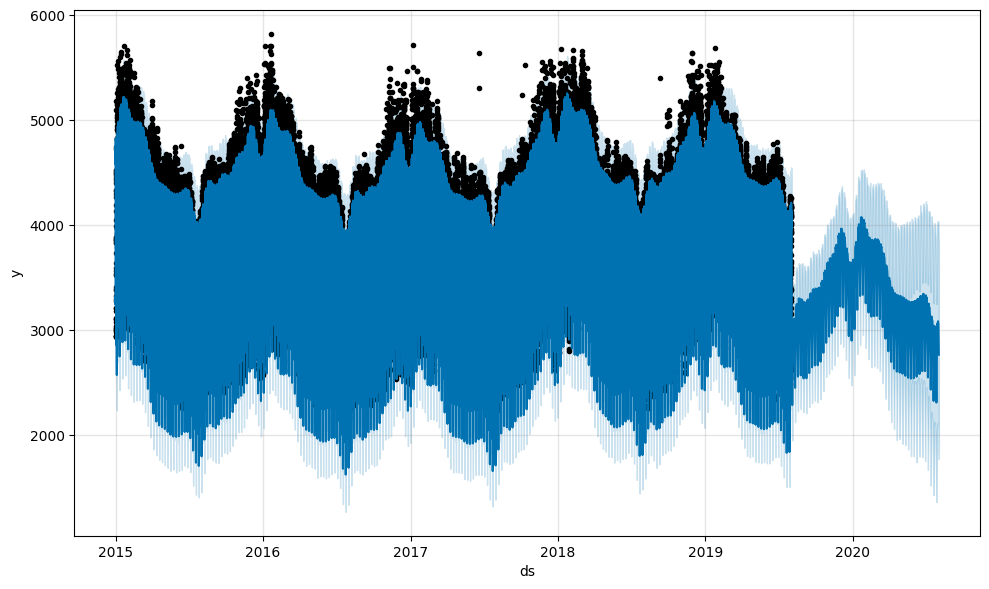

In [120]:
fig = model.plot(dk_pred)

#### Skapar en jämförelse mellan testvärden och förutsagda värde

In [132]:
moments = dk_test[dk_test['ds'].dt.hour == 22]['ds']
load_pred = dk_pred.loc[dk_pred['ds'].isin(moments)]['yhat']
load_test = dk_test.loc[dk_test['ds'].isin(moments)]['y']
for series in [moments, load_pred, load_test]:
    series.index = range(len(series))

df = pd.DataFrame(dict(ds = moments,
                       load_pred = load_pred,
                       load_test = load_test
                   ),
)

fig = px.line(df, x='ds', y=['load_pred', 'load_test'])
fig.show()